#1. Basic Transformer
Made by: Wilfredo Aaron Sosa Ramos

Model: d_model=32, heads=4, enc=1, dec=1, FF=64
Avg Time (sec) for forward pass: 0.004597
------------------------------------------------------------
Model: d_model=64, heads=4, enc=2, dec=2, FF=128
Avg Time (sec) for forward pass: 0.011737
------------------------------------------------------------
Model: d_model=128, heads=8, enc=3, dec=3, FF=256
Avg Time (sec) for forward pass: 0.016090
------------------------------------------------------------
Model: d_model=256, heads=8, enc=4, dec=4, FF=512
Avg Time (sec) for forward pass: 0.042773
------------------------------------------------------------


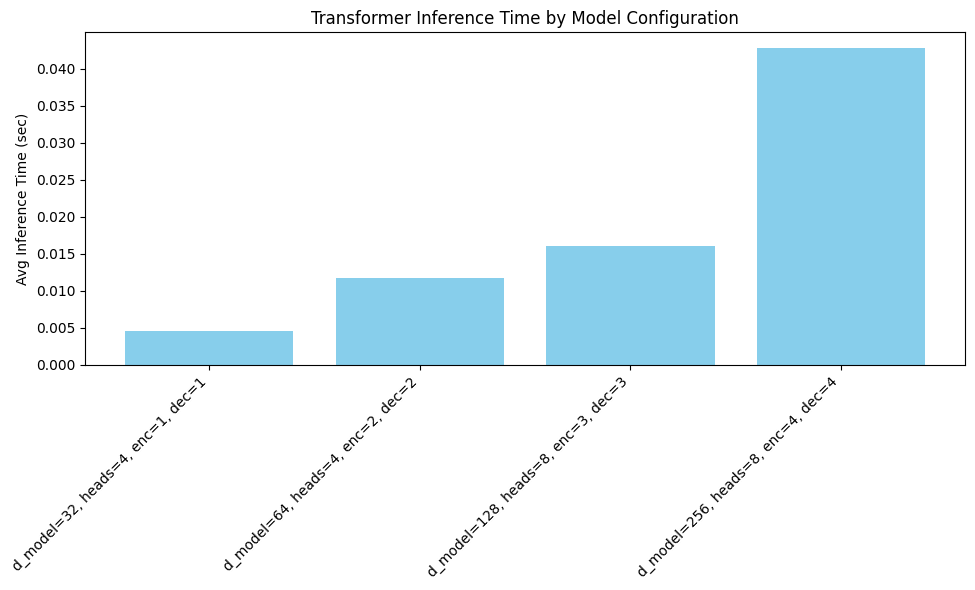

Demo Model Output Logits Shape: torch.Size([2, 10, 1200])
Sample logits (batch=0, pos=0): tensor([-0.3966,  0.6744, -0.0722,  1.6404, -0.9438], grad_fn=<SliceBackward0>)


In [2]:
import math
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class PositionalEncoding(nn.Module):
    """
    This module injects positional information into the token embeddings by using
    sine and cosine functions of different frequencies.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(-math.log(10000.0) * torch.arange(0, d_model, 2).float() / d_model)

        # Even indices: sine, odd indices: cosine
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension for broadcasting
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, d_model]
        Returns the input plus the positional encoding.
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class EncoderLayer(nn.Module):
    """
    Single layer of the Transformer Encoder. It includes:
    1) Multi-head self-attention.
    2) Feed-forward network.
    3) Residual connections and Layer Normalization.
    """
    def __init__(self, d_model, n_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        src shape: [batch_size, src_seq_len, d_model]
        Returns the updated src after self-attention and feed-forward.
        """
        # Self-attention
        attn_output, _ = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask
        )
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feed-forward
        ff_output = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)

        return src

class Encoder(nn.Module):
    """
    Transformer Encoder that consists of:
    1) Token embedding.
    2) Positional encoding.
    3) Stack of encoder layers.
    """
    def __init__(self, input_dim, d_model, n_heads, num_layers, dim_feedforward, max_len=100, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        src shape: [batch_size, src_seq_len]
        Returns the final representation after all encoder layers.
        """
        embedded = self.embedding(src)
        embedded = self.pos_encoding(embedded)
        out = self.dropout(embedded)

        for layer in self.layers:
            out = layer(out, src_mask, src_key_padding_mask)

        return out

class DecoderLayer(nn.Module):
    """
    Single layer of the Transformer Decoder. It includes:
    1) Masked multi-head self-attention.
    2) Multi-head cross-attention (attends the encoder outputs).
    3) Feed-forward network.
    4) Residual connections and Layer Normalization.
    """
    def __init__(self, d_model, n_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt shape: [batch_size, tgt_seq_len, d_model]
        memory shape: [batch_size, src_seq_len, d_model]
        Returns the updated tgt after self-attention and cross-attention.
        """
        # Masked self-attention for autoregressive training
        attn_output, _ = self.self_attn(
            tgt, tgt, tgt,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask
        )
        tgt = tgt + self.dropout1(attn_output)
        tgt = self.norm1(tgt)

        # Cross-attention (queries the encoder output)
        attn_output, _ = self.multihead_attn(
            tgt, memory, memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask
        )
        tgt = tgt + self.dropout2(attn_output)
        tgt = self.norm2(tgt)

        # Feed-forward
        ff_output = self.linear2(self.dropout(torch.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(ff_output)
        tgt = self.norm3(tgt)

        return tgt

class Decoder(nn.Module):
    """
    Transformer Decoder that consists of:
    1) Token embedding.
    2) Positional encoding.
    3) Stack of decoder layers.
    """
    def __init__(self, output_dim, d_model, n_heads, num_layers, dim_feedforward, max_len=100, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt shape: [batch_size, tgt_seq_len]
        memory shape: [batch_size, src_seq_len, d_model]
        Returns the final representation after all decoder layers.
        """
        embedded = self.embedding(tgt)
        embedded = self.pos_encoding(embedded)
        out = self.dropout(embedded)

        for layer in self.layers:
            out = layer(
                out,
                memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

        return out

class Transformer(nn.Module):
    """
    A complete Transformer model that combines Encoder and Decoder, plus a final
    projection layer to get logits over the target vocabulary.
    """
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=512,
        n_heads=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dim_feedforward=2048,
        max_len=100,
        dropout=0.1
    ):
        super().__init__()
        self.encoder = Encoder(
            input_dim=src_vocab_size,
            d_model=d_model,
            n_heads=n_heads,
            num_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        self.decoder = Decoder(
            output_dim=tgt_vocab_size,
            d_model=d_model,
            n_heads=n_heads,
            num_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        self.linear_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(
        self,
        src,
        tgt,
        src_mask=None,
        tgt_mask=None,
        memory_mask=None,
        src_key_padding_mask=None,
        tgt_key_padding_mask=None,
        memory_key_padding_mask=None
    ):
        """
        src shape: [batch_size, src_seq_len]
        tgt shape: [batch_size, tgt_seq_len]
        Returns the logits of size [batch_size, tgt_seq_len, tgt_vocab_size].
        """
        # Encoder forward pass
        memory = self.encoder(src, src_mask, src_key_padding_mask)
        # Decoder forward pass
        output = self.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        # Final linear projection
        logits = self.linear_out(output)
        return logits

def measure_inference_time(
    model,
    src_len,
    tgt_len,
    batch_size,
    src_vocab_size,
    tgt_vocab_size,
    device="cpu",
    repeats=10
):
    """
    Measures the average forward pass time (in seconds) of the given model over 'repeats' iterations.
    """
    src_batch = torch.randint(0, src_vocab_size, (batch_size, src_len)).to(device)
    tgt_batch = torch.randint(0, tgt_vocab_size, (batch_size, tgt_len)).to(device)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)

    # Warm-up run (not measured)
    _ = model(src_batch, tgt_batch, tgt_mask=tgt_mask)

    start_time = time.time()
    for _ in range(repeats):
        _ = model(src_batch, tgt_batch, tgt_mask=tgt_mask)
    end_time = time.time()

    avg_time = (end_time - start_time) / repeats
    return avg_time

if __name__ == "__main__":
    """
    Example usage that prints various results, including average time for different model settings
    and sequence lengths. Then plots the results using matplotlib.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Lists to store results for plotting
    model_sizes = []
    inference_times = []

    # Example parameter sweeps
    param_sweep = [
        (32, 4, 1, 1, 64),    # (d_model, n_heads, enc_layers, dec_layers, dim_feedforward)
        (64, 4, 2, 2, 128),
        (128, 8, 3, 3, 256),
        (256, 8, 4, 4, 512)
    ]

    # We'll measure time for a fixed sequence length, or you can vary those too
    src_len = 10
    tgt_len = 10
    batch_size = 2
    src_vocab_size = 1000
    tgt_vocab_size = 1200

    for (d_model, n_heads, enc_layers, dec_layers, ff_dim) in param_sweep:
        model = Transformer(
            src_vocab_size=src_vocab_size,
            tgt_vocab_size=tgt_vocab_size,
            d_model=d_model,
            n_heads=n_heads,
            num_encoder_layers=enc_layers,
            num_decoder_layers=dec_layers,
            dim_feedforward=ff_dim,
            max_len=100,
            dropout=0.1
        ).to(device)

        avg_time = measure_inference_time(
            model,
            src_len,
            tgt_len,
            batch_size,
            src_vocab_size,
            tgt_vocab_size,
            device=device,
            repeats=10
        )

        # Store results
        model_desc = f"d_model={d_model}, heads={n_heads}, enc={enc_layers}, dec={dec_layers}"
        model_sizes.append(model_desc)
        inference_times.append(avg_time)

        # Print shape checks and some intermediate logs
        print(f"Model: {model_desc}, FF={ff_dim}")
        print(f"Avg Time (sec) for forward pass: {avg_time:.6f}")
        print("-" * 60)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.bar(model_sizes, inference_times, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Avg Inference Time (sec)")
    plt.title("Transformer Inference Time by Model Configuration")
    plt.tight_layout()
    plt.show()

    # Additional demonstration of printing model outputs
    # with one of the configurations from above
    demo_model = Transformer(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        d_model=32,
        n_heads=4,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_feedforward=64,
        max_len=10,
        dropout=0.1
    ).to(device)

    src_demo = torch.randint(0, src_vocab_size, (batch_size, src_len)).to(device)
    tgt_demo = torch.randint(0, tgt_vocab_size, (batch_size, tgt_len)).to(device)
    tgt_mask_demo = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(device)
    logits_demo = demo_model(src_demo, tgt_demo, tgt_mask=tgt_mask_demo)

    print("Demo Model Output Logits Shape:", logits_demo.shape)
    print("Sample logits (batch=0, pos=0):", logits_demo[0, 0, :5])  # Print first 5 logits as example
